In [1]:
import os
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fastbook import *
from fastai.tabular.all import *
import seaborn as sb

This notebook takes the raw/downloaded information and pre-processes it into a data frame. This pre-processing procedure DOES NOT assume all gridded data is in the same spatio-temporal resolution.

In [2]:
# Decide whether to interpolate all the grids to the same spatial resolution (True) or
# point-inspect grids at the original resolution (False).
use_interpolation = True

# Outcome variable (or predictand)

The outcome variable is fuel load per unit area = CC * AGB * BA / CellArea

## Area (Km^2)

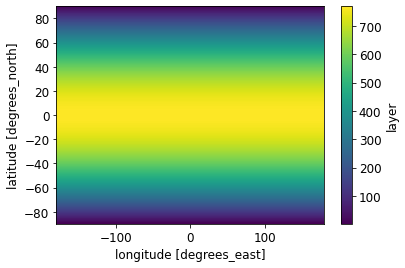

In [3]:
"""Load area data into an xarray dataset"""
area_data = xr.open_mfdataset("/data1/downloaded/area.nc")
area_data = area_data.layer
area_data.plot()

## Combustion completeness (CC)

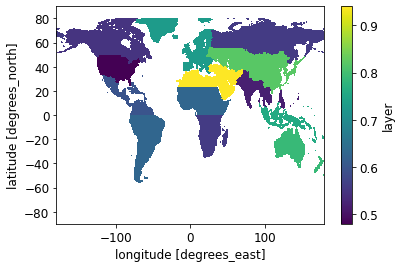

In [4]:
"""Load CC data into an xarray dataset"""
cc_data = xr.open_dataset("/data1/downloaded/GFED4_basis_regions_cc_all.nc")
cc_data = cc_data.layer
cc_data.plot()

## Above Ground Biomass (AGB)

In [5]:
"""Load AGB data into an xarray dataset"""
agb_data = xr.open_dataset("/data1/raw_data/veg_2010_2016/all_veg_data.nc")
agb_data

<xarray.Dataset>
Dimensions:                (latitude: 720, longitude: 1440, time: 84)
Coordinates:
  * time                   (time) datetime64[ns] 2010-01-01 ... 2016-12-01
  * longitude              (longitude) float32 -179.9 -179.6 ... 179.6 179.9
  * latitude               (latitude) float32 -89.88 -89.62 ... 89.62 89.88
Data variables:
    abg_avitabile_vod5th   (time, latitude, longitude) float64 ...
    abg_avitabile_vodmean  (time, latitude, longitude) float64 ...
    abg_avitabile_vod95th  (time, latitude, longitude) float64 ...
    abg_baccini_vod5th     (time, latitude, longitude) float64 ...
    abg_baccini_vodmean    (time, latitude, longitude) float64 ...
    abg_baccini_vod95th    (time, latitude, longitude) float64 ...
    abg_saatchi_vod5th     (time, latitude, longitude) float64 ...
    abg_saatchi_vodmean    (time, latitude, longitude) float64 ...
    abg_saatchi_vod95th    (time, latitude, longitude) float64 ...

Now select below which data variable you would like to use as outcome, this will be used to mask all the other features.

In [6]:
# We suggest to select one of the maps by Avitabile et al.
# This is the outcome variable and also works as mask for all the features.
# All the features geerated from here onwards, will depend on this choice!
agb_vartype = "mean"  # it can be: 'mean' or '5th' or '95th'
author = "avitabile" # it can be: "avitabile", "baccini", "saatchi"
agb_varname = "abg_" + author + "_vod" + agb_vartype

agb_data = eval("agb_data." + agb_varname)
# Units
agb_data.units

'Mg/h'

In [7]:
agb_data

<xarray.DataArray 'abg_avitabile_vodmean' (time: 84, latitude: 720, longitude: 1440)>
[87091200 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2016-12-01
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Attributes:
    long_name:  AGB estimation using a relation Avitabile et al. as a fct of ...
    units:      Mg/h

Please note the units of AGB are Mg/h!

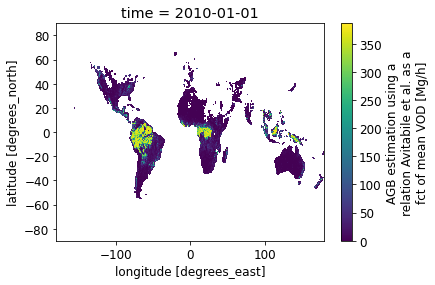

In [8]:
agb_data[0].plot()

In [9]:
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
agb_data = agb_data.loc["2010-04-01":"2016-12-31"]

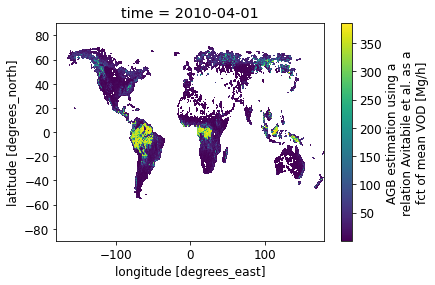

In [10]:
# Mask out where AGB is zero
AGB_THRESH = 0

agb_data = agb_data.where(agb_data > AGB_THRESH)
agb_data[0].plot()

## Burned Area (BA)

In [11]:
"""Load BA data into an xarray dataset"""
ba_source = "ESA-CCI" # it can be 'ESA-CCI' or 'GFED4'

if ba_source == "ESA-CCI":
    ba_data = xr.open_mfdataset(
        "/data1/raw_data/burned_area_2010_2018/201[0-6]*-ESACCI-L4_FIRE-BA-MODIS-fv5.1.nc"
    )
    # Extract only burned areas
    ba_data = ba_data.burned_area
    # Please note the units of BA are m2! Units: ba_data.units
    # Convert m2 to hectares
    ba_data = ba_data * 0.0001
    # Rename lat/lon dimensions
    ba_data = ba_data.rename({"lon": "longitude", "lat": "latitude"})
elif ba_source == "GFED4":
    ba_data = xr.open_mfdataset(
        "/data1/downloaded/GFED_nc_2010_2016/gfed_burned_area_20*.nc"
    )
    # Rename lat/lon dimensions
    ba_data = ba_data.rename({"lon": "longitude", "lat": "latitude"})
    # Convert area from Km2 to hectares
    area_data_h = area_data * 100
    ba_data = ba_data.burned_fraction * area_data_h

In [12]:
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
ba_data = ba_data.loc["2010-04-01":"2016-12-31"]

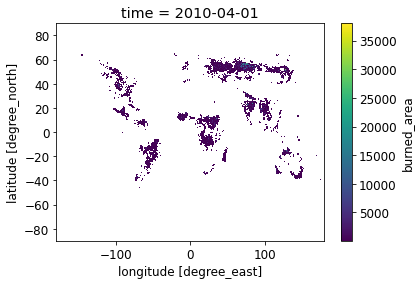

In [13]:
# Mask out low values (small fires)
BA_THRESH = 50  # hectares
ba_data = ba_data.where(ba_data > BA_THRESH)

ba_data[0].plot()

## Dry Matter (DM)

The fuel load or dry matter (Mg/Km2) is the Above Ground Biomass (Mg/h) * Burned Area (h) * Combustion Completeness (this is unitless rate) / the area of each cell (Km2). This operation is straightforward because the grids have the same spatial and temporal resolution! Please note the result shows values where BA, CC and AGB are not equal to NA. 

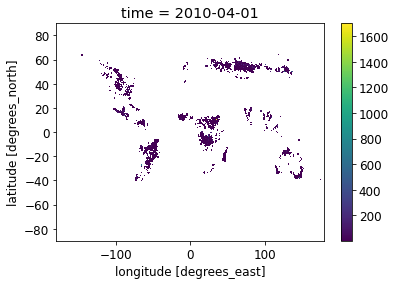

In [14]:
load_data = agb_data * ba_data * cc_data / area_data
load_data[0].plot()

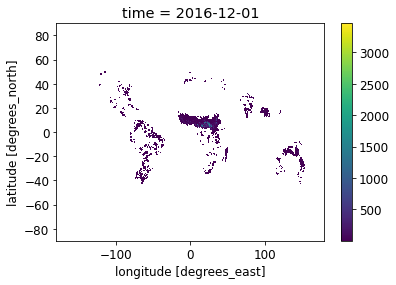

In [15]:
load_data[80].plot()

In [16]:
# Store data, if needed.
# folder_path = "/home/moc0/ai-vegetation-fuel/data/inputs/drymatter/"
# Path(folder_path).mkdir(parents=True, exist_ok=True)
# load_data.to_netcdf(folder_path + "drymatter_Mg_over_Km2_2010-2016_" + ba_source + "_" + agb_varname + ".nc")

In [17]:
load_data

<xarray.DataArray (time: 81, latitude: 720, longitude: 1440)>
dask.array<truediv, shape=(81, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9

In [18]:
# Convert cells with non missing values to dataframe
df = load_data.to_dataframe(name="fuel_load").dropna().reset_index()
df

,time,latitude,longitude,fuel_load
0,2010-04-01,-39.875,-65.375,0.235708
1,2010-04-01,-39.625,-73.125,5.152665
2,2010-04-01,-39.375,175.125,15.806868
3,2010-04-01,-39.125,-72.375,7.532907
4,2010-04-01,-39.125,-72.125,21.445339
...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282
720463,2016-12-01,48.125,-120.125,9.861333
720464,2016-12-01,49.125,-0.375,2.790013
720465,2016-12-01,49.125,-0.125,1.610908


In [19]:
df['fuel_load'].describe()

count    720467.000000
mean         81.575953
std         228.129134
min           0.000003
25%           2.829180
50%          12.308750
75%          56.434086
max       12042.022608
Name: fuel_load, dtype: float64

In [20]:
# Example: retrieve data at the grid cells nearest to the target latitudes, longitudes and time
# y = x["index"].sel(longitude=target_lon, latitude=target_lat, time=target_t, method="nearest")
# Where
target_lon = xr.DataArray(df['longitude'], dims="points")
target_lat = xr.DataArray(df['latitude'], dims="points")
target_t = xr.DataArray(df['time'], dims="points")

# Static predictors

## Climatic regions (categorical)

In [21]:
"""Load climatic regions data into an xarray dataset"""
cr_data = xr.open_dataset("/data1/raw_data/Beck_KG_V1_present_0p0083.gridName0320.nc")

# Rotate longitude coordinates
cr_data = cr_data.assign_coords(
    longitude=(((cr_data.longitude + 180) % 360) - 180)
).sortby("longitude")

cr_data = cr_data.climatic_region
cr_data

<xarray.DataArray 'climatic_region' (latitude: 601, longitude: 1200)>
[721200 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 90.0 89.7 89.4 89.1 ... -89.4 -89.7 -90.0
  * longitude  (longitude) float64 -180.0 -179.7 -179.4 ... 179.1 179.4 179.7
Attributes: (12/28)
    GRIB_paramId:                             212028
    GRIB_shortName:                           ~
    GRIB_units:                               ~
    GRIB_name:                                Experimental product
    GRIB_cfVarName:                           p28.212
    GRIB_dataType:                            af
    ...                                       ...
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    long_name:                                Experimental product
    units:                                    ~
    coordinates:                              time step heightAboveGround lat...

In [22]:
if use_interpolation == True:
    # Interpolate to match load resolution
    cr_data = cr_data.interp(
        coords={
            "latitude": load_data.latitude.values,
            "longitude": load_data.longitude.values,
        },
        method="nearest",
    )

# Retrieve data at the grid cells nearest to the target latitudes and longitudes
df["climatic_region"] = cr_data.sel(longitude=target_lon,
                                    latitude=target_lat,
                                    method="nearest")

The climatic regions are 5 categories (1 to 5), the floating number make me think they might have been previously pre-processed in the wrong way. Let's fix this by rounding to the nearest integer. Conversion to categorical type should be done just before modelling (as it is lost when saving data to csv).

In [23]:
df["climatic_region"] = df["climatic_region"].round()
df

,time,latitude,longitude,fuel_load,climatic_region
0,2010-04-01,-39.875,-65.375,0.235708,1.0
1,2010-04-01,-39.625,-73.125,5.152665,NaN
2,2010-04-01,-39.375,175.125,15.806868,3.0
3,2010-04-01,-39.125,-72.375,7.532907,3.0
4,2010-04-01,-39.125,-72.125,21.445339,3.0
...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0
720463,2016-12-01,48.125,-120.125,9.861333,1.0
720464,2016-12-01,49.125,-0.375,2.790013,NaN
720465,2016-12-01,49.125,-0.125,1.610908,NaN


## Biomes (categorical)

In [24]:
"""Load slope data into an xarray dataset"""
biomes_data = xr.open_dataset("/data1/downloaded/landcover_25.nc")
# Convert to data array and select the only time step available
biomes_data = biomes_data.STRF[0]
biomes_data

<xarray.DataArray 'STRF' (latitude: 720, longitude: 1440)>
[1036800 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    time       datetime64[ns] 2000-01-01
Attributes:
    long_name:  Stream function
    units:      m**2 s**-1
    code:       1
    table:      255

In [25]:
# No need to interpolate, spatial resolution already matching the load

# Retrieve data at the grid cells nearest to the target latitudes and longitudes
df["biome"] = biomes_data.sel(longitude=target_lon,
                              latitude=target_lat,
                              method="nearest")
    
df

,time,latitude,longitude,fuel_load,climatic_region,biome
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0
...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0


## GFED basis region (categorical)

In [26]:
"""Load GFED basis region into an xarray dataset"""
gfedregions_data = xr.open_mfdataset("/data1/downloaded/GFED4_basis_regions_id.nc")

gfedregions_data = gfedregions_data.layer
gfedregions_data

<xarray.DataArray 'layer' (latitude: 720, longitude: 1440)>
dask.array<open_dataset-25361df0b18e7609ff770980d8a035bblayer, shape=(720, 1440), dtype=float32, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
Attributes:
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=...
    min:           1.0
    max:           14.0

In [27]:
# No need to interpolate, spatial resolution already matching the load

# Retrieve data at the grid cells nearest to the target latitudes and longitudes
df["GFEDregions"] = gfedregions_data.sel(longitude=target_lon,
                                         latitude=target_lat,
                                         method="nearest")
    
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0
...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0


## Slope

In [28]:
"""Load slope data into an xarray dataset"""
slope_data = xr.open_mfdataset("/data1/raw_data/slope_O320.nc")
slope_data = slope_data.slor

# Rotate longitude coordinates
slope_data = slope_data.assign_coords(
    longitude=(((slope_data.longitude + 180) % 360) - 180)
).sortby("longitude")

slope_data

<xarray.DataArray 'slor' (latitude: 601, longitude: 1200)>
dask.array<getitem, shape=(601, 1200), dtype=float32, chunksize=(601, 1200), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.7 89.4 89.1 ... -89.4 -89.7 -90.0
  * longitude  (longitude) float64 -180.0 -179.7 -179.4 ... 179.1 179.4 179.7
Attributes: (12/28)
    GRIB_paramId:                             163
    GRIB_shortName:                           slor
    GRIB_units:                               ~
    GRIB_name:                                Slope of sub-gridscale orography
    GRIB_cfVarName:                           slor
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    long_name:                                Slope of sub-gridscale orography
    units:                                    ~
    coordinates:                              time step surface latitude long...

In [29]:
if use_interpolation == True:
    # Interpolate to match load resolution
    slope_data = slope_data.interp(
        coords={
            "latitude": load_data.latitude.values,
            "longitude": load_data.longitude.values,
        },
        method="nearest",
    )

# Retrieve data at the grid cells nearest to the target latitudes and longitudes
df["slope"] = slope_data.sel(longitude=target_lon,
                             latitude=target_lat,
                             method="nearest")

df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126
...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559


# Dynamic predictors

## Vegetation Optical Depth (VDO)

In [30]:
"""Load VOD data into an xarray dataset"""
vodfiles = [
    os.path.join(d, x)
    for year in range(2010, 2017)
    for d, dirs, files in os.walk("/data1/downloaded/ESA_VOD/" + str(year))
    for x in files
    if x.endswith(".nc")
]
vod_data = xr.open_mfdataset(vodfiles)
vod_data = vod_data.SM_IDW

# Calculate monthly means
vod_data = vod_data.resample(time="1MS").mean(dim="time")

vod_data

<xarray.DataArray 'SM_IDW' (time: 81, latitude: 450, longitude: 900)>
dask.array<stack, shape=(81, 450, 900), dtype=float64, chunksize=(1, 450, 900), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 -90.0 -89.6 -89.2 -88.8 ... 88.8 89.2 89.6

Please note this data is limited between 2010-04-01 and 2016-12-31!

In [31]:
if use_interpolation == True:
    # Interpolate to match load resolution
    vod_data = vod_data.interp(
        coords={
            "latitude": load_data.latitude.values,
            "longitude": load_data.longitude.values,
        },
        method="nearest",
    )

# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["vod"] = vod_data.sel(longitude=target_lon,
                         latitude=target_lat,
                         time=target_t,
                         method="nearest")

df

/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935
...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777


## Leaf Area Index (LAI)

According to [this wiki](https://wiki.landscapetoolbox.org/doku.php/remote_sensing_methods:leaf-area_index), remote sensing LAI methods generate a map of dimensionless LAI values assigned to each pixel. Values can range from 0 (bare ground) to 6 or more, but since rangeland vegetation is generally sparse, values commonly range from 0-1. A LAI value of 1 means that there is the equivalent of 1 layer of leaves that entirely cover a unit of ground surface area, and less than one means that there is some bare ground between vegetated patches. LAI values over 1 indicate a layered canopy with multiple layers of leaves per unit ground surface area. LAI and fPAR data are commonly packaged together (e.g., MODIS products).

In [32]:
"""Load LAI data into an xarray dataset"""
lai_data = xr.open_mfdataset(
    "/data1/raw_data/LAI_interpolated_2010_2017/LAI_201[0-6]*.nc"
)
lai_data = lai_data.LAI
# Rename lat/lon dimensions
lai_data = lai_data.rename({"lon": "longitude", "lat": "latitude"})
# Calculate monthly means
lai_data = lai_data.resample(time="1MS").mean(dim="time")
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
lai_data = lai_data.loc["2010-04-01":"2016-12-31"]
lai_data

<xarray.DataArray 'LAI' (time: 81, latitude: 560, longitude: 1440)>
dask.array<getitem, shape=(81, 560, 1440), dtype=float32, chunksize=(1, 560, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
  * latitude   (latitude) float64 -59.88 -59.62 -59.38 ... 79.38 79.62 79.88
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9

In [33]:
if use_interpolation == True:
    # Interpolate to match load resolution
    lai_data = lai_data.interp(
        coords={
            "latitude": load_data.latitude.values,
            "longitude": load_data.longitude.values,
        },
        method="nearest",
    )

# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["lai"] = lai_data.sel(longitude=target_lon,
                         latitude=target_lat,
                         time=target_t,
                         method="nearest")

df

/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod,lai
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971,0.655549
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954,2.144423
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961,3.433299
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958,1.811093
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935,4.477733
...,...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193,0.777770
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260,0.655549
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282,0.599994
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777,1.111100


## Standardised Precipitation Index

In [34]:
"""Load SPI data into an xarray dataset"""
spi_data = xr.open_mfdataset("/data1/raw_data/SPI_GPCC/output_201[0-6]*.nc")

# Rotate longitude coordinates
spi_data = spi_data.assign_coords(
    longitude=(((spi_data.longitude + 180) % 360) - 180)
).sortby("longitude")

# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
spi_data = spi_data.loc[dict(time=slice("2010-04-01", "2016-12-31"))]

# Fix time stamps
spi_data["time"] = load_data["time"]

spi_data

<xarray.Dataset>
Dimensions:    (latitude: 601, longitude: 1200, time: 81)
Coordinates:
  * latitude   (latitude) float64 90.0 89.7 89.4 89.1 ... -89.4 -89.7 -90.0
  * longitude  (longitude) float64 -180.0 -179.7 -179.4 ... 179.1 179.4 179.7
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
Data variables:
    spi03      (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    spi06      (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    spi12      (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-03-24T08:59:39 GRIB to CDM+CF via cfgrib-0....

In [35]:
if use_interpolation == True:
    # Interpolate to match load resolution
    spi_data = spi_data.interp(
        coords={
            "latitude": load_data.latitude.values,
            "longitude": load_data.longitude.values,
        },
        method="nearest",
    )

# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["spi03"] = spi_data["spi03"].sel(longitude=target_lon,
                                    latitude=target_lat,
                                    time=target_t,
                                    method="nearest")
df["spi06"] = spi_data["spi06"].sel(longitude=target_lon,
                                    latitude=target_lat,
                                    time=target_t,
                                    method="nearest")
df["spi12"] = spi_data["spi12"].sel(longitude=target_lon,
                                    latitude=target_lat,
                                    time=target_t,
                                    method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,spi06,spi12
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971,0.655549,0.776954,0.525000,-0.447657
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954,2.144423,-0.711328,0.038671,0.396093
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961,3.433299,-1.662499,-1.019922,-0.342188
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958,1.811093,-0.465234,0.118750,0.388281
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935,4.477733,-0.428124,0.118750,0.384375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193,0.777770,-0.266016,-0.875389,0.050391
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260,0.655549,0.026953,-0.254295,-0.213281
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282,0.599994,-1.494532,-2.109764,-0.639062
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777,1.111100,-1.486719,-2.152733,-0.605859


## Weather Anomalies

In [36]:
"""Load Weather data into an xarray dataset"""
wa_data = xr.open_mfdataset("/data1/raw_data/SEAS5_anomalies/S5_anomaly_201[0-6]*.nc")

# Rotate longitude coordinates
wa_data = wa_data.assign_coords(
    longitude=(((wa_data.longitude + 180) % 360) - 180)
).sortby("longitude")

# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
wa_data = wa_data.loc[dict(time=slice("2010-04-01", "2016-12-31"))]
wa_data

<xarray.Dataset>
Dimensions:    (latitude: 451, longitude: 900, time: 81)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    erate      (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    fg10       (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    si10       (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    tprate     (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-11-19 14:28:47 GMT by grib_to_netcdf-2.17.1: grib_to_n...

In [37]:
if use_interpolation == True:
    # Interpolate to match load resolution
    wa_data = wa_data.interp(
        coords={
            "latitude": load_data.latitude.values,
            "longitude": load_data.longitude.values,
        },
        method="nearest",
    )

# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["d2m"] = wa_data["d2m"].sel(longitude=target_lon,
                               latitude=target_lat,
                               time=target_t,
                               method="nearest")
df["erate"] = wa_data["erate"].sel(longitude=target_lon,
                                   latitude=target_lat,
                                   time=target_t,
                                   method="nearest")
df["fg10"] = wa_data["fg10"].sel(longitude=target_lon,
                                 latitude=target_lat,
                                 time=target_t,
                                 method="nearest")
df["si10"] = wa_data["si10"].sel(longitude=target_lon,
                                 latitude=target_lat,
                                 time=target_t,
                                 method="nearest")
df["swvl1"] = wa_data["swvl1"].sel(longitude=target_lon,
                                   latitude=target_lat,
                                   time=target_t,
                                   method="nearest")
df["t2m"] = wa_data["t2m"].sel(longitude=target_lon,
                               latitude=target_lat,
                               time=target_t,
                               method="nearest")
df["tprate"] = wa_data["tprate"].sel(longitude=target_lon,
                                     latitude=target_lat,
                                     time=target_t,
                                     method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,spi06,spi12,d2m,erate,fg10,si10,swvl1,t2m,tprate
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971,0.655549,0.776954,0.525000,-0.447657,0.406953,0.827660,-196.723999,-154.286743,0.003297,0.254569,1.853317
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954,2.144423,-0.711328,0.038671,0.396093,0.287460,3.016632,431.780701,28.249649,0.005519,0.299962,55.425812
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961,3.433299,-1.662499,-1.019922,-0.342188,0.013466,-3.028435,755.989075,154.893127,0.050565,-0.337244,32.763611
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958,1.811093,-0.465234,0.118750,0.388281,0.387394,5.030487,413.472107,42.046005,0.016681,0.273752,71.841888
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935,4.477733,-0.428124,0.118750,0.384375,0.381312,6.291336,393.559875,-27.938068,0.003139,0.076797,92.562195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193,0.777770,-0.266016,-0.875389,0.050391,-1.367281,1.625626,292.504852,59.417725,0.006094,-1.379390,9.860245
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260,0.655549,0.026953,-0.254295,-0.213281,0.455697,0.501305,-115.465073,-19.559784,-0.018831,0.631343,-2.685104
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282,0.599994,-1.494532,-2.109764,-0.639062,-0.879230,-2.990351,710.314941,152.261505,0.015199,-0.608153,6.517075
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777,1.111100,-1.486719,-2.152733,-0.605859,-0.919799,-2.017698,706.356201,156.933868,0.015889,-0.627131,4.443192


## Fire anomalies

In [38]:
"""Load fire data into an xarray dataset"""
fa_data = xr.open_mfdataset(
    "/data1/raw_data/SEAS_FIRE_ANOMALIES_2010_2018/ECMWF_FWI_201[0-6]*_anomaly_m1.nc"
)
# Rename lat/lon dimensions
fa_data = fa_data.rename({"lon": "longitude", "lat": "latitude"})
# Rotate longitude coordinates
fa_data = fa_data.assign_coords(
    longitude=(((fa_data.longitude + 180) % 360) - 180)
).sortby("longitude")

# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
fa_data = fa_data.loc[dict(time=slice("2010-04-01", "2016-12-31"))]

# Fix time stamps
fa_data["time"] = load_data["time"]

fa_data

<xarray.Dataset>
Dimensions:      (latitude: 640, longitude: 1280, time: 81)
Coordinates:
  * time         (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
  * longitude    (longitude) float64 -180.0 -179.7 -179.4 ... 179.2 179.4 179.7
  * latitude     (latitude) float64 89.78 89.51 89.23 ... -89.23 -89.51 -89.78
Data variables:
    danger_risk  (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    fwinx        (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    ffmcode      (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    dufmcode     (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    drtcode      (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    infsinx      (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    fbupinx      (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    fdsrte       (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Apr 25 20:57:44 2021: cdo -R -f nc -remapbil,n320 -setg...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [39]:
if use_interpolation == True:
    # Interpolate to match load resolution
    fa_data = fa_data.interp(
        coords={
            "latitude": load_data.latitude.values,
            "longitude": load_data.longitude.values,
        },
        method="nearest",
    )

# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["danger_risk"] = fa_data["danger_risk"].sel(longitude=target_lon,
                                               latitude=target_lat,
                                               time=target_t,
                                               method="nearest")
df["fwinx"] = fa_data["fwinx"].sel(longitude=target_lon,
                                   latitude=target_lat,
                                   time=target_t,
                                   method="nearest")
df["ffmcode"] = fa_data["ffmcode"].sel(longitude=target_lon,
                                       latitude=target_lat,
                                       time=target_t,
                                       method="nearest")
df["dufmcode"] = fa_data["dufmcode"].sel(longitude=target_lon,
                                         latitude=target_lat,
                                         time=target_t,
                                         method="nearest")
df["drtcode"] = fa_data["drtcode"].sel(longitude=target_lon,
                                       latitude=target_lat,
                                       time=target_t,
                                       method="nearest")
df["infsinx"] = fa_data["infsinx"].sel(longitude=target_lon,
                                       latitude=target_lat,
                                       time=target_t,
                                       method="nearest")
df["fbupinx"] = fa_data["fbupinx"].sel(longitude=target_lon,
                                       latitude=target_lat,
                                       time=target_t,
                                       method="nearest")
df["fdsrte"] = fa_data["fdsrte"].sel(longitude=target_lon,
                                     latitude=target_lat,
                                     time=target_t,
                                     method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,spi06,spi12,d2m,erate,fg10,si10,swvl1,t2m,tprate,danger_risk,fwinx,ffmcode,dufmcode,drtcode,infsinx,fbupinx,fdsrte
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971,0.655549,0.776954,0.525000,-0.447657,0.406953,0.827660,-196.723999,-154.286743,0.003297,0.254569,1.853317,-0.408514,-6.540662,0.409787,-28.476147,-435.756500,-0.604823,-48.407936,-5.157768
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954,2.144423,-0.711328,0.038671,0.396093,0.287460,3.016632,431.780701,28.249649,0.005519,0.299962,55.425812,-0.067000,-0.084618,6.273533,-0.538086,-20.080078,0.267007,-0.873047,-0.086460
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961,3.433299,-1.662499,-1.019922,-0.342188,0.013466,-3.028435,755.989075,154.893127,0.050565,-0.337244,32.763611,0.218694,1.595769,6.249068,3.641309,6.909269,0.687314,5.850041,0.220082
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958,1.811093,-0.465234,0.118750,0.388281,0.387394,5.030487,413.472107,42.046005,0.016681,0.273752,71.841888,-0.128096,-0.487267,4.348554,-1.812235,-52.787262,0.159193,-3.456243,-0.198016
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935,4.477733,-0.428124,0.118750,0.384375,0.381312,6.291336,393.559875,-27.938068,0.003139,0.076797,92.562195,-0.099173,-0.372817,4.207914,-1.145141,-49.045151,0.194680,-3.067599,-0.133346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193,0.777770,-0.266016,-0.875389,0.050391,-1.367281,1.625626,292.504852,59.417725,0.006094,-1.379390,9.860245,-0.001600,0.213408,3.380115,0.573486,2.652710,0.321904,0.713867,0.011017
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260,0.655549,0.026953,-0.254295,-0.213281,0.455697,0.501305,-115.465073,-19.559784,-0.018831,0.631343,-2.685104,0.000000,-0.034499,-4.597795,-0.155521,-92.605637,-0.084250,-0.304651,-0.000867
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282,0.599994,-1.494532,-2.109764,-0.639062,-0.879230,-2.990351,710.314941,152.261505,0.015199,-0.608153,6.517075,-0.002031,0.067574,0.882902,0.393799,131.938141,0.012117,0.793365,0.001631
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777,1.111100,-1.486719,-2.152733,-0.605859,-0.919799,-2.017698,706.356201,156.933868,0.015889,-0.627131,4.443192,-0.002258,0.045247,0.583693,0.309570,123.781250,-0.005449,0.623535,0.000401


## Fire Radiative Power (FRP)

In [40]:
# Get data using /perm/mo/moc0/repos/wildfiretools/sh/CAMS_Observations_daily.sh to /vol/fproj/frp/
# cdo monavg /vol/fproj/frp/CAMS_daily_2010-04-01_2016-12-31.nc /vol/fproj/frp/CAMS_daily_2010-04-01_2016-12-31_monavg.nc
# cdo consects /vol/fproj/frp/CAMS_daily_2010-04-01_2016-12-31.nc /vol/fproj/frp/CAMS_daily_2010-04-01_2016-12-31_consecutive_days.nc
# cdo monavg /vol/fproj/frp/CAMS_daily_2010-04-01_2016-12-31_consecutive_days.nc /vol/fproj/frp/CAMS_daily_2010-04-01_2016-12-31_consecutive_days_monavg.nc

In [41]:
"""Load FRP data into an xarray dataset"""
frp_data = xr.open_dataset("/data1/downloaded/CAMS_frpfire/CAMS_daily_2010-04-01_2016-12-31_monavg.nc")
frp_data = frp_data.frpfire

# Fix time stamps
frp_data["time"] = load_data["time"]

# Rotate longitude coordinates
frp_data = frp_data.assign_coords(
    longitude=(((frp_data.longitude + 180) % 360) - 180)
).sortby("longitude")

frp_data

<xarray.DataArray 'frpfire' (time: 81, latitude: 1800, longitude: 3600)>
[524880000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
Attributes:
    long_name:     Wildfire radiative power
    units:         W m**-2
    cell_methods:  time: mean

In [42]:
if use_interpolation == True:
    # Interpolate to match load resolution
    frp_data = frp_data.interp(
        coords={
            "latitude": load_data.latitude.values,
            "longitude": load_data.longitude.values,
        },
        method="nearest",
    )

# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["frp"] = frp_data.sel(longitude=target_lon,
                         latitude=target_lat,
                         time=target_t,
                         method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,spi06,spi12,d2m,erate,fg10,si10,swvl1,t2m,tprate,danger_risk,fwinx,ffmcode,dufmcode,drtcode,infsinx,fbupinx,fdsrte,frp
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971,0.655549,0.776954,0.525000,-0.447657,0.406953,0.827660,-196.723999,-154.286743,0.003297,0.254569,1.853317,-0.408514,-6.540662,0.409787,-28.476147,-435.756500,-0.604823,-48.407936,-5.157768,0.000000
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954,2.144423,-0.711328,0.038671,0.396093,0.287460,3.016632,431.780701,28.249649,0.005519,0.299962,55.425812,-0.067000,-0.084618,6.273533,-0.538086,-20.080078,0.267007,-0.873047,-0.086460,0.019714
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961,3.433299,-1.662499,-1.019922,-0.342188,0.013466,-3.028435,755.989075,154.893127,0.050565,-0.337244,32.763611,0.218694,1.595769,6.249068,3.641309,6.909269,0.687314,5.850041,0.220082,0.000000
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958,1.811093,-0.465234,0.118750,0.388281,0.387394,5.030487,413.472107,42.046005,0.016681,0.273752,71.841888,-0.128096,-0.487267,4.348554,-1.812235,-52.787262,0.159193,-3.456243,-0.198016,0.007889
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935,4.477733,-0.428124,0.118750,0.384375,0.381312,6.291336,393.559875,-27.938068,0.003139,0.076797,92.562195,-0.099173,-0.372817,4.207914,-1.145141,-49.045151,0.194680,-3.067599,-0.133346,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193,0.777770,-0.266016,-0.875389,0.050391,-1.367281,1.625626,292.504852,59.417725,0.006094,-1.379390,9.860245,-0.001600,0.213408,3.380115,0.573486,2.652710,0.321904,0.713867,0.011017,0.000000
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260,0.655549,0.026953,-0.254295,-0.213281,0.455697,0.501305,-115.465073,-19.559784,-0.018831,0.631343,-2.685104,0.000000,-0.034499,-4.597795,-0.155521,-92.605637,-0.084250,-0.304651,-0.000867,0.000000
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282,0.599994,-1.494532,-2.109764,-0.639062,-0.879230,-2.990351,710.314941,152.261505,0.015199,-0.608153,6.517075,-0.002031,0.067574,0.882902,0.393799,131.938141,0.012117,0.793365,0.001631,0.000000
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777,1.111100,-1.486719,-2.152733,-0.605859,-0.919799,-2.017698,706.356201,156.933868,0.015889,-0.627131,4.443192,-0.002258,0.045247,0.583693,0.309570,123.781250,-0.005449,0.623535,0.000401,0.000000


## Feature engineering

In [43]:
# Check data types by column
df.dtypes

time               datetime64[ns]
latitude                  float64
longitude                 float64
fuel_load                 float64
climatic_region           float32
biome                     float64
GFEDregions               float32
slope                     float32
vod                       float64
lai                       float32
spi03                     float32
spi06                     float32
spi12                     float32
d2m                       float32
erate                     float32
fg10                      float32
si10                      float32
swvl1                     float32
t2m                       float32
tprate                    float32
danger_risk               float32
fwinx                     float32
ffmcode                   float32
dufmcode                  float32
drtcode                   float32
infsinx                   float32
fbupinx                   float32
fdsrte                    float32
frp                       float32
dtype: object

In [44]:
# Drop NAN and reset the index
df = df.dropna().reset_index(drop=True)
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,spi06,spi12,d2m,erate,fg10,si10,swvl1,t2m,tprate,danger_risk,fwinx,ffmcode,dufmcode,drtcode,infsinx,fbupinx,fdsrte,frp
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971,0.655549,0.776954,0.525000,-0.447657,0.406953,0.827660,-196.723999,-154.286743,0.003297,0.254569,1.853317,-0.408514,-6.540662,0.409787,-28.476147,-435.756500,-0.604823,-48.407936,-5.157768,0.000000
1,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961,3.433299,-1.662499,-1.019922,-0.342188,0.013466,-3.028435,755.989075,154.893127,0.050565,-0.337244,32.763611,0.218694,1.595769,6.249068,3.641309,6.909269,0.687314,5.850041,0.220082,0.000000
2,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958,1.811093,-0.465234,0.118750,0.388281,0.387394,5.030487,413.472107,42.046005,0.016681,0.273752,71.841888,-0.128096,-0.487267,4.348554,-1.812235,-52.787262,0.159193,-3.456243,-0.198016,0.007889
3,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935,4.477733,-0.428124,0.118750,0.384375,0.381312,6.291336,393.559875,-27.938068,0.003139,0.076797,92.562195,-0.099173,-0.372817,4.207914,-1.145141,-49.045151,0.194680,-3.067599,-0.133346,0.000000
4,2010-04-01,-38.875,-73.125,24.395179,3.0,1.0,5.0,0.007279,0.527810,4.866618,-0.637109,0.067968,0.353125,0.548470,-2.832302,243.483215,25.360672,0.026732,0.346304,36.827591,0.001888,0.155949,4.679501,-1.645196,4.946845,0.350790,-1.998169,-0.181037,0.003937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662536,2016-12-01,45.125,2.375,19.511560,3.0,1.0,6.0,0.012388,0.337806,1.122211,-0.680079,-1.228905,0.064063,-1.342800,2.017982,228.148102,32.137329,0.007165,-1.386452,11.752808,0.001543,0.293289,3.657032,0.905957,2.282520,0.338811,1.021387,0.018449,0.000000
662537,2016-12-01,45.125,2.625,120.068342,2.0,1.0,6.0,0.017362,0.325193,0.599994,-0.484766,-1.055077,0.069922,-1.367281,1.625626,292.504852,59.417725,0.006094,-1.379390,9.860245,-0.000420,0.246845,3.500041,0.730444,2.304420,0.331265,0.832579,0.014133,0.000000
662538,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193,0.777770,-0.266016,-0.875389,0.050391,-1.367281,1.625626,292.504852,59.417725,0.006094,-1.379390,9.860245,-0.001600,0.213408,3.380115,0.573486,2.652710,0.321904,0.713867,0.011017,0.000000
662539,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260,0.655549,0.026953,-0.254295,-0.213281,0.455697,0.501305,-115.465073,-19.559784,-0.018831,0.631343,-2.685104,0.000000,-0.034499,-4.597795,-0.155521,-92.605637,-0.084250,-0.304651,-0.000867,0.000000


Calculate time elapsed (in days) since 2010-01-01 

In [45]:
def elapsed_days(last_date):
    return (last_date - datetime(2010, 1, 1)).dt.days

In [46]:
# Extract month and year from time, as well as other dateparts
df['daysElapsed'] = elapsed_days(df['time'])
df['timeYear'] = df['time'].dt.year
df['timeMonth'] = df['time'].dt.month
df = df.drop('time', axis = 1)

In [47]:
# Check data types by column
df.dtypes

latitude           float64
longitude          float64
fuel_load          float64
climatic_region    float32
biome              float64
GFEDregions        float32
slope              float32
vod                float64
lai                float32
spi03              float32
spi06              float32
spi12              float32
d2m                float32
erate              float32
fg10               float32
si10               float32
swvl1              float32
t2m                float32
tprate             float32
danger_risk        float32
fwinx              float32
ffmcode            float32
dufmcode           float32
drtcode            float32
infsinx            float32
fbupinx            float32
fdsrte             float32
frp                float32
daysElapsed          int64
timeYear             int64
timeMonth            int64
dtype: object

## Save data frame with raw features

In [48]:
df.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/full_dataset_interp" + str(use_interpolation) + ".csv", index=False)

### Splitting dataset into train/test sets and targets

I want to make sure in train and test data we have approximately the same proportion of biomes. In order to achieve that we use stratified sampling.

In [49]:
train, test = train_test_split(df,
                               test_size=0.2,
                               stratify=df[["biome"]],
                               random_state=1)

In [50]:
train.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/train_raw_interp" + str(use_interpolation) + ".csv")
test.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/test_raw_interp" + str(use_interpolation) + ".csv")

## Exploratory Data Analysis

In [51]:
# train = pd.read_csv("/home/moc0/ai-vegetation-fuel/data/inputs/train_interpTrue.csv")
# train = train.drop(['Unnamed: 0'], axis = 1)
# train.describe()

In [52]:
# Define categorical and numerical features
target = ['fuel_load']
cat = ['climatic_region', 'biome', 'GFEDregions']
cont = train.columns.to_list()
for i in cat + target:
    cont.remove(i)
cols_to_display = ['fuel_load'] + cont
print(cols_to_display)

['fuel_load', 'latitude', 'longitude', 'slope', 'vod', 'lai', 'spi03', 'spi06', 'spi12', 'd2m', 'erate', 'fg10', 'si10', 'swvl1', 't2m', 'tprate', 'danger_risk', 'fwinx', 'ffmcode', 'dufmcode', 'drtcode', 'infsinx', 'fbupinx', 'fdsrte', 'frp', 'daysElapsed', 'timeYear', 'timeMonth']


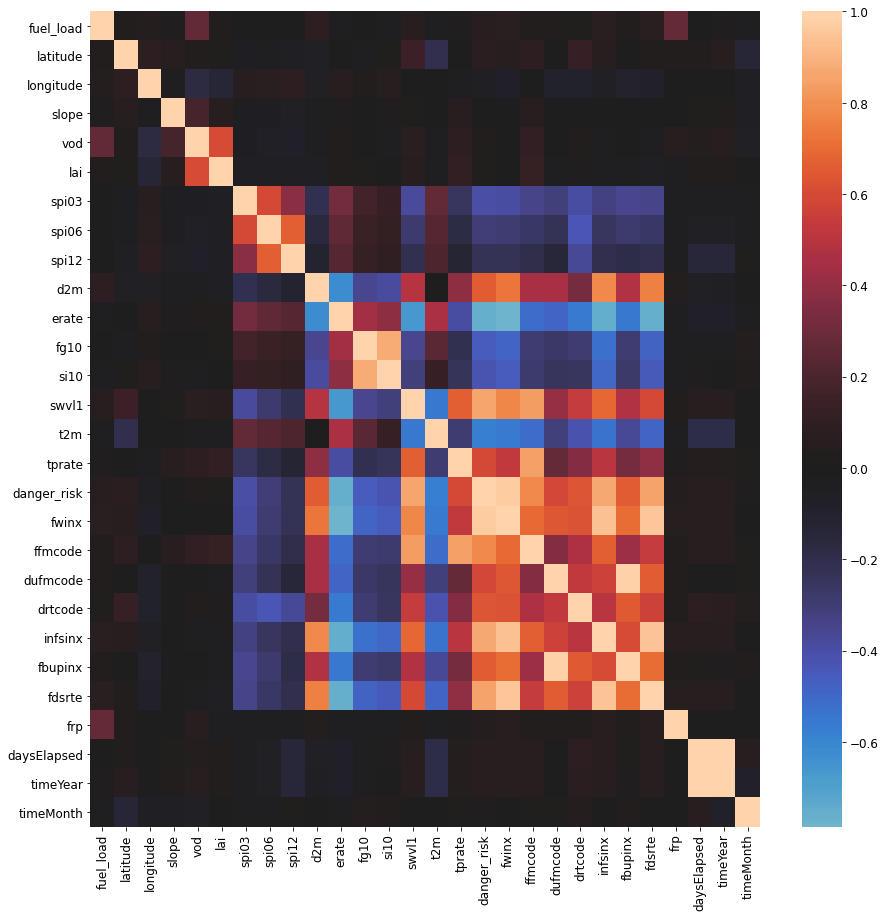

In [53]:
# Correlation matrix
C_mat = train[cols_to_display].corr()
fig = plt.figure(figsize = (15, 15))

sb.heatmap(C_mat, center=0)
plt.show()

array([[<AxesSubplot:title={'center':'fuel_load'}>, <AxesSubplot:title={'center':'latitude'}>, <AxesSubplot:title={'center':'longitude'}>, <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'vod'}>, <AxesSubplot:title={'center':'lai'}>],
       [<AxesSubplot:title={'center':'spi03'}>, <AxesSubplot:title={'center':'spi06'}>, <AxesSubplot:title={'center':'spi12'}>, <AxesSubplot:title={'center':'d2m'}>,
        <AxesSubplot:title={'center':'erate'}>, <AxesSubplot:title={'center':'fg10'}>],
       [<AxesSubplot:title={'center':'si10'}>, <AxesSubplot:title={'center':'swvl1'}>, <AxesSubplot:title={'center':'t2m'}>, <AxesSubplot:title={'center':'tprate'}>,
        <AxesSubplot:title={'center':'danger_risk'}>, <AxesSubplot:title={'center':'fwinx'}>],
       [<AxesSubplot:title={'center':'ffmcode'}>, <AxesSubplot:title={'center':'dufmcode'}>, <AxesSubplot:title={'center':'drtcode'}>, <AxesSubplot:title={'center':'infsinx'}>,
        <AxesSubplot:title={'center':'fbupin

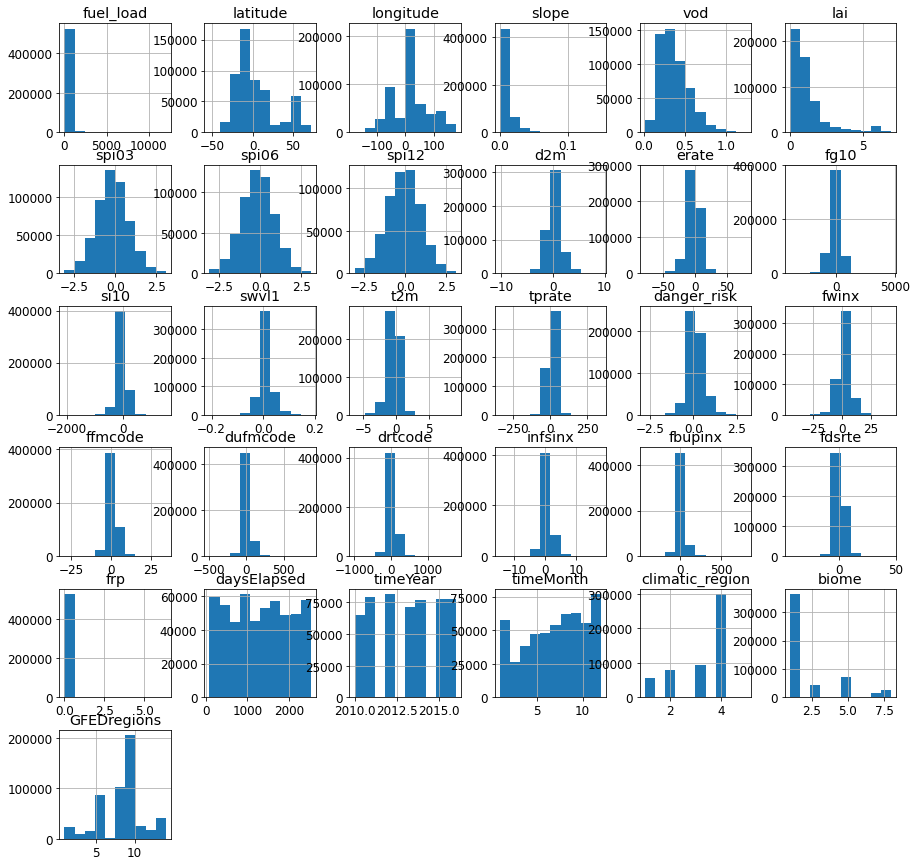

In [54]:
# Are all the features normally distributed?
train[target + cont + cat].hist(figsize = (15,15))

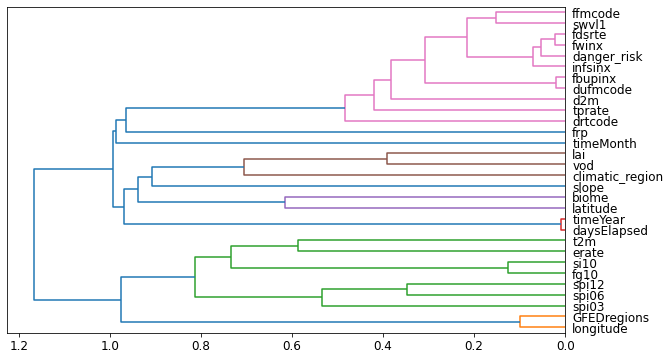

In [55]:
# Identify important vs redundand features
cluster_columns(train.drop(target, axis = 1))

The variables in the above dataset vary in different ranges. On the one hand, this is not a problem for Decision Trees, Random Forest because these algorithm care about the order of the data, not the scale. AutoML with H2O, implements automatic normalisation.
For Deep Learning models this is a problem and in the next section I show how to remove skeweness (e.g. using a logarithmic transformation) and normalise the data.

At least 4 variables look left skewed: fuel_load, slope, vod and lai. Let's apply a log-transformation.
Note that the log-transformation can be applied only to values that are > 0 (log of 0 and negative number is undefined). The minimum of 2 variables (lai and frp) is zero, therefore we will have to filter out these zeros before transforming the data.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc2c474d160>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc2c474d190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc2c474d880>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc2c47717f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc2c4771880>],
 'means': []}

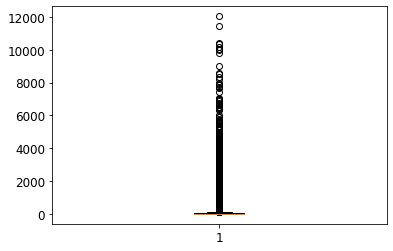

In [56]:
# Are there outliers in fuel_load?
plt.boxplot(train.fuel_load)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc27280f2e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc27280feb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc2730ec2b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc27280fdc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc273107190>],
 'means': []}

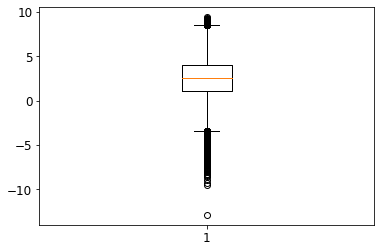

In [57]:
plt.boxplot(np.log(train.fuel_load))

It is convenient to log transform variables that show pronounced skeweness. A comparison of various approaches is presented in model_definition_benchmark.ipynb